In [81]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle as pk
import sys as sys
from sys import exc_info
import ast
from scipy.sparse import csr_matrix

In [82]:
ratings = pd.read_csv('./ratings_small.csv', usecols = ['userId', 'movieId','rating'])
print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n') 

Shape of ratings dataset is:  (100004, 3) 

Max values in dataset are 
 userId        671.0
movieId    163949.0
rating          5.0
dtype: float64 

Min values in dataset are 
 userId     1.0
movieId    1.0
rating     0.5
dtype: float64 



In [83]:
# Filtering data for only 4+ ratings
ratings = ratings[ratings['rating'] >= 4.0]
print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n') 

Shape of ratings dataset is:  (51568, 3) 

Max values in dataset are 
 userId        671.0
movieId    163949.0
rating          5.0
dtype: float64 

Min values in dataset are 
 userId     1.0
movieId    1.0
rating     4.0
dtype: float64 



In [84]:
movies_list = np.unique(ratings['movieId'])[:200]
ratings = ratings.loc[ratings['movieId'].isin(movies_list)]
print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n') 

Shape of ratings dataset is:  (3591, 3) 

Max values in dataset are 
 userId     671.0
movieId    249.0
rating       5.0
dtype: float64 

Min values in dataset are 
 userId     2.0
movieId    1.0
rating     4.0
dtype: float64 



In [85]:
users_list = np.unique(ratings['userId'])[:100]
ratings = ratings.loc[ratings['userId'].isin(users_list)]
print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n')
print('Total Users: ', np.unique(ratings['userId']).shape[0])
print('Total Movies which are rated by 100 users: ', np.unique(ratings['movieId']).shape[0]) 

Shape of ratings dataset is:  (678, 3) 

Max values in dataset are 
 userId     116.0
movieId    249.0
rating       5.0
dtype: float64 

Min values in dataset are 
 userId     2.0
movieId    1.0
rating     4.0
dtype: float64 

Total Users:  100
Total Movies which are rated by 100 users:  148


In [86]:
users_fav_movies = ratings.loc[:, ['userId', 'movieId']]

In [87]:
users_fav_movies = ratings.reset_index(drop = True)


In [88]:
users_fav_movies.T


,0,1,2,3,4,5,6,7,8,9,...,668,669,670,671,672,673,674,675,676,677
userId,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,...,114.0,114.0,114.0,114.0,115.0,115.0,115.0,115.0,116.0,116.0
movieId,10.0,17.0,39.0,47.0,50.0,110.0,150.0,153.0,222.0,110.0,...,34.0,158.0,185.0,208.0,2.0,3.0,19.0,231.0,47.0,231.0
rating,4.0,5.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,4.0,...,5.0,4.0,4.0,4.0,5.0,5.0,4.0,4.5,5.0,5.0


In [89]:
def get_user_movies_list(users_data):
    # users = a list of users IDs
    # users_data = a dataframe of users favourite movies or users watched movies

    users = np.unique(users_data['userId'])
    result = []
    for user in users:
        result.append(str(list(users_data[users_data['userId'] == user]['movieId'])).split('[')[1].split(']')[0])
    return result


In [90]:
from scipy.sparse import csr_matrix

user_movies_list = get_user_movies_list(users_fav_movies)

def prepSparseMatrix(list_of_str):
    # list_of_str = A list, which contain strings of users favourite movies separate by comma ",".
    # It will return us sparse matrix and feature names on which sparse matrix is defined 
    # i.e. name of movies in the same order as the column of sparse matrix
    cv = CountVectorizer(token_pattern = r'[^\,\ ]+', lowercase = False)
    sparseMatrix = cv.fit_transform(list_of_str)
    return sparseMatrix.toarray(), cv.get_feature_names_out()

users = np.unique(users_fav_movies['userId'])
sparseMatrix, feature_names = prepSparseMatrix(user_movies_list)
df_sparseMatrix = pd.DataFrame(sparseMatrix, index = users, columns = feature_names)
df_sparseMatrix

,1,10,100,101,104,105,107,11,110,111,...,81,82,85,86,88,89,9,92,95,97
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
113,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
114,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
# Calculate the average rating and the total number of ratings per movie
user_item_matrix['avg_rating'] = user_item_matrix.mean(axis=1)
user_item_matrix['num_ratings'] = (user_item_matrix > 0).sum(axis=1)


In [103]:
kmeans = KMeans(n_clusters=12, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(sparseMatrix)

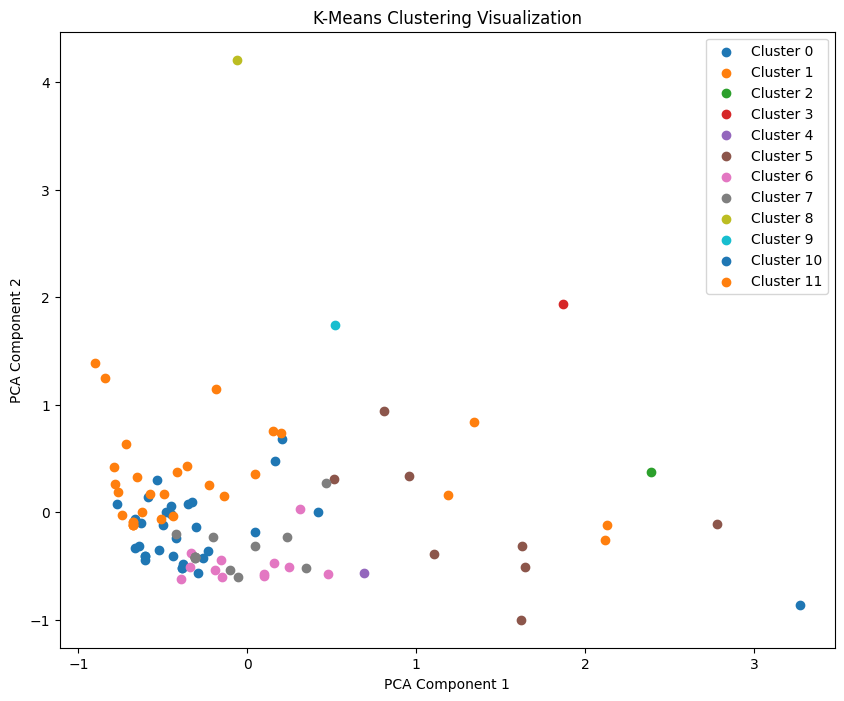

In [104]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sparseMatrix)  # Use sparseMatrix directly

# Add the cluster labels to the result
x_pca = pca_result[:, 0]
y_pca = pca_result[:, 1]

# Plot the PCA-transformed data with cluster labels
plt.figure(figsize=(10, 8))
for cluster in range(12):  # Adjust for the number of clusters
    cluster_points = (clusters == cluster)
    plt.scatter(x_pca[cluster_points], y_pca[cluster_points], label=f"Cluster {cluster}")

# Add titles and labels
plt.title("K-Means Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


In [97]:
users_cluster = pd.DataFrame(np.concatenate((users.reshape(-1,1), clusters.reshape(-1,1)), axis = 1), columns = ['userId', 'Cluster'])
users_cluster.T


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
userId,2,3,4,5,6,7,8,9,10,11,...,106,108,109,110,111,112,113,114,115,116
Cluster,0,3,3,1,1,3,5,1,12,12,...,1,1,1,8,0,1,6,1,1,1


In [102]:
# Group data by clusters to compute summary statistics
cluster_summary = user_item_matrix.groupby('Cluster').agg(
    avg_rating=('avg_rating', 'mean'),       # Mean of average ratings in the cluster
    total_ratings=('num_ratings', 'sum'),   # Total number of ratings in the cluster
    count=('Cluster', 'size')               # Number of items in the cluster
)

# Print the cluster summary
print(cluster_summary)


KeyError: 'Cluster'

In [ ]:
# Check if 'Cluster' column exists in user_item_matrix
print(user_item_matrix.columns)


Index([            1,             2,             3,             5,
                   6,             7,             8,             9,
                  10,            11,
       ...
              160567,        160590,        160718,        161944,
              162376,        162542,        163949,     'Cluster',
        'avg_rating', 'num_ratings'],
      dtype='object', name='movieId', length=6173)


In [ ]:
from sklearn.cluster import KMeans

# Define the number of clusters (adjust based on elbow method)
num_clusters = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
user_item_matrix['Cluster'] = kmeans.fit_predict(user_item_matrix.values)


In [ ]:
# Exclude 'Cluster' column for calculations
data_for_calc = user_item_matrix.drop('Cluster', axis=1)

# Calculate the average rating per user
user_item_matrix['avg_rating'] = data_for_calc.mean(axis=1)

# Calculate the number of ratings per user
user_item_matrix['num_ratings'] = (data_for_calc > 0).sum(axis=1)


In [ ]:
# Group data by 'Cluster' to compute summary statistics
cluster_summary = user_item_matrix.groupby('Cluster').agg(
    avg_rating=('avg_rating', 'mean'),        # Average of users' average ratings in the cluster
    total_ratings=('num_ratings', 'sum'),     # Total number of ratings in the cluster
    user_count=('Cluster', 'size')            # Number of users in the cluster
)

# Display the cluster summary
print(cluster_summary)


         avg_rating  total_ratings  user_count
Cluster                                       
0          0.031075          19091         512
1          0.364021          10647          25
2          0.137220          21022         132
3          0.929238           2150           2


In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Step 1: Filter the data for ratings >= 4
filtered_ratings = ratings_data[ratings_data['rating'] >= 4]

# Step 2: Create a user-item matrix
user_item_matrix = filtered_ratings.pivot(index='userId', columns='movieId', values='rating')

# Step 3: Fill NaN values with 0 (users didn't rate those movies)
user_item_matrix = user_item_matrix.fillna(0)

# Step 4: Convert the matrix into a sparse format for efficient computation
sparse_user_item_matrix = csr_matrix(user_item_matrix)


In [ ]:
# Step 1: Initialize the KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)

# Step 2: Fit the KNN model on the sparse matrix
knn.fit(sparse_user_item_matrix)

# Step 3: Query the model for recommendations
# Example: Find the 5 nearest neighbors for the first user
user_index = 0  # Index of the user in the matrix
distances, indices = knn.kneighbors(user_item_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=5)

# Display the results
print(f"Nearest Neighbors for User {user_index + 1}:")
for i, (distance, index) in enumerate(zip(distances[0], indices[0])):
    print(f"{i + 1}. User {index + 1} (Distance: {distance:.4f})")


Nearest Neighbors for User 1:
1. User 1 (Distance: 0.0000)
2. User 539 (Distance: 0.8507)
3. User 280 (Distance: 0.8546)
4. User 341 (Distance: 0.8578)
5. User 669 (Distance: 0.8649)


In [ ]:
# Step 1: Get the movies rated by the queried user
user_rated_movies = user_item_matrix.iloc[user_index, :]
user_rated_movies = user_rated_movies[user_rated_movies > 0].index

# Step 2: Get the movies rated by the nearest neighbors
neighbor_indices = indices[0][1:]  # Skip the first neighbor as it's the user itself
neighbor_ratings = user_item_matrix.iloc[neighbor_indices, :]

# Step 3: Recommend movies
recommendations = neighbor_ratings.mean(axis=0)  # Average rating of movies by neighbors
recommendations = recommendations[~recommendations.index.isin(user_rated_movies)]  # Exclude already rated movies
recommendations = recommendations.sort_values(ascending=False).head(5)  # Top 5 recommendations

print("Recommended Movies:")
print(recommendations)


Recommended Movies:
movieId
260      2.50
17       2.25
2396     2.00
36527    1.25
326      1.25
dtype: float64
